## 1. Load packages

In [1]:
import MatrixV3
from MatrixV3 import RecommendationMeasureStevenZ as rm 
import numpy as np
import pandas as pd


## 2. Set up the path (optional)

In [2]:
import os
os.chdir('C:\\Users\\zheng\\Downloads')

## 3. Load dataset




df0 is the original training data (initial load)<br>
df1 is the dataset removed n recommendation<br>
df_pred is the output from model. *Make sure its the same dimension as df0<br>
rand_pred is the random prediction from df1.<br>


In [ ]:
np.random.seed(seed_value)
df1 = rm.randomize_remove_n(df0,12)

In [3]:
df0 = pd.read_csv('df_training_1k.csv')
df = df0
df1 = rm.randomize_remove_n(df0,12)

data = df1.melt(id_vars=['user_id'], var_name='app_id', value_name='rating')
data = data[data['rating'] != 0]
data['rating'] = data['rating'].replace(1, 2) # Change 1s to 2s
data['rating'] = data['rating'].replace(-1, 1) # Then change -1s to 1s
data['app_id'] = data['app_id'].astype(int)

# Different type of Predcition:

## Random prediction

accuracy could be vary since it's random predicting

In [18]:
rand_pred1 = rm.generate_random_prediction(df1,1)
rand_pred3 = rm.generate_random_prediction(df1,3)
rand_pred5 = rm.generate_random_prediction(df1,5)
rand_pred9 = rm.generate_random_prediction(df1,9)
rand_pred12 = rm.generate_random_prediction(df1,12)

## Model I

In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def calculate_popularity(data):
    # Calculate the popularity of each game
    popularity = data.apply(lambda x: x > 0).sum().sort_values(ascending=False)
    return popularity

def create_recommendation_dataframe(data, n):
    # make sure we have column for 'user_id'
    if 'user_id' in data.index.names:
        data.reset_index(inplace=True)

    user_ids = data['user_id']
    game_data = data.drop('user_id', axis=1)
    all_games = game_data.columns.tolist()  # all column of game ID
    popularity = calculate_popularity(game_data).index[:n]  # get most top n popular game

    cosine_sim = cosine_similarity(game_data)
    recommendations = pd.DataFrame(0, index=user_ids, columns=all_games)

    for idx, user_id in enumerate(user_ids):
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        most_similar_users = [sim_scores[i][0] for i in range(1, 6)]
        
        similar_users_likes = game_data.iloc[most_similar_users].sum(axis=0)
        top_games = similar_users_likes.sort_values(ascending=False).head(n).index
        
        recommendations.loc[user_id, top_games] = 1

        # Check and fill insufficient testimonials
        if recommendations.loc[user_id].sum() < n:
            needed = n - recommendations.loc[user_id].sum()
            recommendations.loc[user_id, popularity[:needed]] = 1

    recommendations['user_id'] = user_ids  # Re-add the user_id column
    return recommendations

In [24]:
final_recommendations_1 = create_recommendation_dataframe(df1, n=1)
final_recommendations_3 = create_recommendation_dataframe(df1, n=3)
final_recommendations_5 = create_recommendation_dataframe(df1, n=5)
final_recommendations_9 = create_recommendation_dataframe(df1, n=9)
final_recommendations_12 = create_recommendation_dataframe(df1, n=12)

## Model II

In [ ]:
reader = Reader(rating_scale=(1, 2))
sup_data = Dataset.load_from_df(data[['user_id', 'app_id', 'rating']], reader)

sup_train = sup_data.build_full_trainset()
algo = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 30 , init_std_dev = 0.05)
algo.fit(sup_train)

In [ ]:
def prediction_algo(uid = None , iid = None):
    predictions = []
    if uid is None:
        for ui in sup_train.all_users():
            predictions.append(algo.predict(ui, iid, verbose = False))
        return predictions

    if iid is None:
        for ii in sup_train.all_items():
            ii = sup_train.to_raw_iid(ii)
            predictions.append(algo.predict(uid, ii, verbose = False))
        return predictions
    return predictions.append(algo.predict(uid,iid,verbose = False))

def worker(user_id, prediction_algo, n):
    predictions = prediction_algo(uid=user_id)
    top_n_iids = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    top_n_iids = [str(pred.iid) for pred in top_n_iids]  # Use str(pred.iid)
    return user_id, top_n_iids

def create_recommendation_matrix(df, prediction_algo, n, num_workers=10):
    user_ids = df['user_id'].tolist()  # Convert to list for ordered iteration
    app_ids = df.columns[1:].tolist()  # First column is 'user_id'

    # Initialize the recommendation dataframe with zeros
    recommendations_df = pd.DataFrame(0, index=user_ids, columns=app_ids, dtype=int)

    # Use a ThreadPoolExecutor to parallelize the recommendation process
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_user_id = {executor.submit(worker, user_id, prediction_algo, n): user_id for user_id in user_ids}

        for future in as_completed(future_to_user_id):
            user_id, top_n_iids = future.result()
            recommendations_df.loc[user_id, top_n_iids] = 1

    # Reset index to make user_id a column
    recommendations_df.reset_index(inplace=True)
    recommendations_df.rename(columns={'index': 'user_id'}, inplace=True)
    
    return recommendations_df

## 4. Check Accuracy with Different n

#### Random Guess:

In [19]:
rand_acc1 = rm.calculate_recommendation_accuracy(df0, rand_pred1)
print("Prediction accuracy for 1 random guess:", "{:.2f}%".format(rand_acc1 * 100))

Prediction accuracy for 1 random guess: 0.20%


In [20]:
rand_acc3 = rm.calculate_recommendation_accuracy(df0, rand_pred3)
print("Prediction accuracy for 3 random guess:", "{:.2f}%".format(rand_acc3 * 100))

Prediction accuracy for 3 random guess: 0.60%


In [21]:
rand_acc5 = rm.calculate_recommendation_accuracy(df0, rand_pred5)
print("Prediction accuracy for 5 random guess:", "{:.2f}%".format(rand_acc5 * 100))

Prediction accuracy for 5 random guess: 1.80%


In [22]:
rand_acc9 = rm.calculate_recommendation_accuracy(df0, rand_pred9)
print("Prediction accuracy for 9 random guess:", "{:.2f}%".format(rand_acc9 * 100))

Prediction accuracy for 9 random guess: 2.90%


In [23]:
rand_acc12 = rm.calculate_recommendation_accuracy(df0, rand_pred12)
print("Prediction accuracy for 12 random guess:", "{:.2f}%".format(rand_acc12 * 100))

Prediction accuracy for 12 random guess: 5.00%


#### Model 1 prediction:

In [25]:
recom_acc1 = rm.calculate_recommendation_accuracy(df0, final_recommendations_1)
print("Prediction accuracy for n = 1 :", "{:.2f}%".format(recom_acc1 * 100))

Prediction accuracy for n = 1 : 6.30%


In [26]:
recom_acc3 = rm.calculate_recommendation_accuracy(df0, final_recommendations_3)
print("Prediction accuracy for n = 3 :", "{:.2f}%".format(recom_acc3 * 100))

Prediction accuracy for n = 3 : 14.00%


In [27]:
recom_acc5 = rm.calculate_recommendation_accuracy(df0, final_recommendations_5)
print("Prediction accuracy for n = 5 :", "{:.2f}%".format(recom_acc5 * 100))

Prediction accuracy for n = 5 : 19.40%


In [28]:
recom_acc9 = rm.calculate_recommendation_accuracy(df0, final_recommendations_9)
print("Prediction accuracy for n = 9 :", "{:.2f}%".format(recom_acc9 * 100))

Prediction accuracy for n = 9 : 29.60%


In [29]:
recom_acc12 = rm.calculate_recommendation_accuracy(df0, final_recommendations_12)
print("Prediction accuracy for n = 12 :", "{:.2f}%".format(recom_acc12 * 100))

Prediction accuracy for n = 12 : 34.30%


#### Model 2 predcition:

In [ ]:
N_values = [1, 3, 5, 9, 12]

# Initialize an empty list to store the results
results = []

# Loop through the values of N
for N in N_values:
    # Call the recommendation function
    recommendation_matrix = create_recommendation_matrix(df, prediction_algo, N, num_workers=10)

    # Calculate the recommendation accuracy and precision
    recom_acc = rm.calculate_recommendation_accuracy(df, recommendation_matrix)
    recom_prec = rm.estimate_precision(df, recommendation_matrix,12)
    # Store N and the accuracy in the results list
    results.append({'N': N, 'Model II Accuracy': recom_acc * 100, 'Model II Precision': recom_prec *100})


results_df = pd.DataFrame(results)
results_df

In [36]:
M2_recommendations_1 = pd.read_csv('recommendation_matrix_1.csv', index_col=0)
M2_recommendations_3 = pd.read_csv('recommendation_matrix_3.csv',index_col=0)
M2_recommendations_5 = pd.read_csv('recommendation_matrix_5.csv', index_col=0)
M2_recommendations_9 = pd.read_csv('recommendation_matrix_9.csv', index_col=0)
M2_recommendations_12 = pd.read_csv('recommendation_matrix_12.csv', index_col=0)

In [46]:
N_values = [1, 3, 5, 9, 12]

# Initialize an empty list to store the results
results = []

for N in N_values:

    recommendation_matrix = globals()['M2_recommendations_' + str(N)]

    recom_acc = rm.calculate_recommendation_accuracy(df, recommendation_matrix)
    recom_prec = rm.estimate_precision(df, recommendation_matrix,N)    
    # Store N, accuracy, and precision in the results list
    results.append({'N': N, 'Model II Accuracy': recom_acc * 100, 'Model II Precision': recom_prec * 100})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
results_df

,N,Model II Accuracy,Model II Precision
0,1,8.5,8.500000
1,3,20.2,9.400000
2,5,29.7,9.680000
3,9,43.8,9.711111
4,12,50.1,9.566667


### Plot Accuarcy

In [51]:
acc_data = {
    'N': [1, 3, 5, 9, 12],
    'Random Guess': [rand_acc1,rand_acc3,rand_acc5,rand_acc9,rand_acc12],
    'Model I Accuracy': [recom_acc1, recom_acc3, recom_acc5, recom_acc9, recom_acc12],
}

accuracy_df = pd.DataFrame(acc_data)

accuracy_df['Random Guess'] *= 100
accuracy_df['Model I Accuracy'] *= 100
accuracy_df['Model II Accuracy'] = results_df['Model II Accuracy']
accuracy_df

,N,Random Guess,Model I Accuracy,Model II Accuracy
0,1,0.2,6.3,8.5
1,3,0.6,14.0,20.2
2,5,1.8,19.4,29.7
3,9,2.9,29.6,43.8
4,12,5.0,34.3,50.1


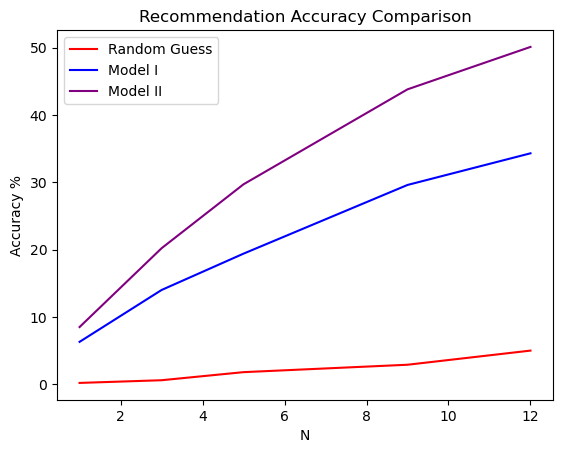

In [52]:
import matplotlib.pyplot as plt

plt.plot(accuracy_df['N'], accuracy_df['Random Guess'], label='Random Guess', color='red')
plt.plot(accuracy_df['N'], accuracy_df['Model I Accuracy'], label='Model I', color='blue')
plt.plot(accuracy_df['N'], accuracy_df['Model II Accuracy'], label='Model II', color='purple')

plt.xlabel('N')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('Recommendation Accuracy Comparison')

plt.show()







## 5. Check Precision with Different n

Random Guess

In [53]:
rand_prec1 = rm.estimate_precision(df0, rand_pred1,1)
rand_prec3 = rm.estimate_precision(df0, rand_pred3,3)
rand_prec5 = rm.estimate_precision(df0, rand_pred5,5)
rand_prec9 = rm.estimate_precision(df0, rand_pred9,9)
rand_prec12 = rm.estimate_precision(df0, rand_pred12,12)


Model I

In [35]:
def estimate_precision(df0, df_pred, n):
        """
        Count the total number of occurrences of the value 2 in the DataFrame.

        Parameters:
            df (DataFrame): Input DataFrame.

        Returns:
            int: Total number of occurrences of the value 2.
        """
        matrix_df0 = df0.values
        matrix_df_pred = df_pred.values
        matrix_sum = matrix_df0 + matrix_df_pred

        result_df = pd.DataFrame(matrix_sum, columns=df0.columns, index=df0.index)
        num_rows_2 = result_df.values.ravel().tolist().count(2)
        precision = num_rows_2 / (df0.shape[0]*n)
        return precision

In [37]:
from MatrixV3 import RecommendationMeasureStevenZ as rm 

In [44]:
recom_prec1 = rm.estimate_precision(df0, final_recommendations_1,1)
recom_prec3 = rm.estimate_precision(df0, final_recommendations_3,3)
recom_prec5 = rm.estimate_precision(df0, final_recommendations_5,5)
recom_prec9 = rm.estimate_precision(df0, final_recommendations_9,9)
recom_prec12 = rm.estimate_precision(df0, final_recommendations_12,12)

In [54]:
prec_data = {
    'N': [1, 3, 5, 9, 12],
    'Random Guess': [rand_prec1,rand_prec3,rand_prec5,rand_prec9,rand_prec12],
    'Model I Precision': [recom_prec1, recom_prec3, recom_prec5, recom_prec9, recom_prec12],
}

precision_df = pd.DataFrame(prec_data)
precision_df['Random Guess'] *= 100
precision_df['Model I Precision'] *= 100
precision_df['Model II Precision'] = results_df['Model II Precision']
precision_df

,N,Random Guess,Model I Precision,Model II Precision
0,1,0.200000,6.300000,8.500000
1,3,0.200000,5.666667,9.400000
2,5,0.360000,5.480000,9.680000
3,9,0.333333,5.244444,9.711111
4,12,0.441667,4.933333,9.566667


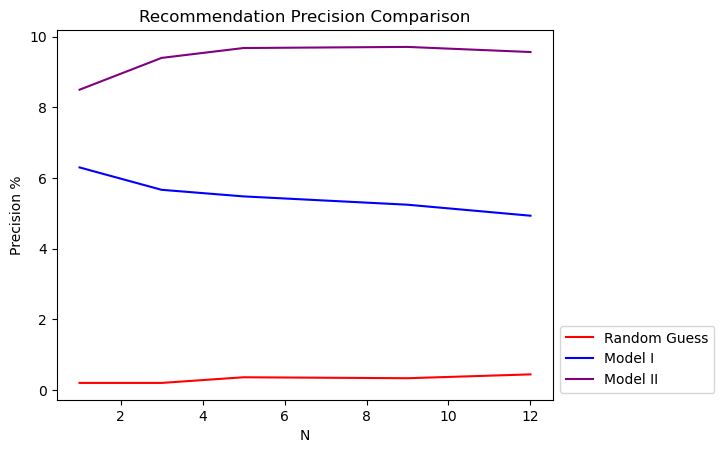

In [64]:
plt.plot(precision_df['N'], precision_df['Random Guess'], label='Random Guess', color='red')
plt.plot(precision_df['N'], precision_df['Model I Precision'], label='Model I', color='blue')
plt.plot(precision_df['N'], precision_df['Model II Precision'], label='Model II', color='purple')

plt.xlabel('N')
plt.ylabel('Precision %')
plt.legend()
plt.title('Recommendation Precision Comparison')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()





